# SSH or Streamfunction?

We try out potential ways to make a divide between heat gain and heat loss regions. Specifically, we have the following ideas:

1. Using streamfunction, or
2. Using SSH 

to separate the subtropical from subpolar and polar gyres, and to heat up the subtropics, cool down the subpolar regions. 

In [1]:
import cartopy.crs as ccrs
import cosima_cookbook as cc
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean as cm
from dask.distributed import Client
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

# Avoid the Runtime errors in true_divide encountered when trying to divide by zero
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)
warnings.filterwarnings('ignore', category = ResourceWarning)
warnings.filterwarnings('ignore', category = BytesWarning)

# matplotlib stuff:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['lines.linewidth'] = 2.0
matplotlib.rc('xtick', labelsize = 18) 
matplotlib.rc('ytick', labelsize = 18)

import logging
logger = logging.getLogger("distributed.utils_perf")
logger.setLevel(logging.ERROR)

from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 16,Total memory: 64.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38713,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 16
Started: Just now,Total memory: 64.00 GiB
Comm: tcp://127.0.0.1:42217,Total threads: 4
Dashboard: /proxy/37957/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:40111,


In [2]:
db = '/scratch/x77/db6174/access-om2/archive/databases/cc_database_param_kpp_extended2.db'
session = cc.database.create_session(db)
expt = '025deg_jra55_ryf_param_kpp_extended2'

## A. Using streamfunction

In [3]:
rho0 = 1026
st = '2000-01-01'
et = '2009-12-31'

tx_trans = cc.querying.getvar(expt = expt, session = session, variable = 'tx_trans_int_z', frequency = '1 monthly').sel(time = slice(st, et))
psi = -tx_trans.cumsum('yt_ocean').where(abs(tx_trans<=1.e20))/(rho0*1.e6)

In [4]:
psi_acc = np.nanmin(psi.sel(xu_ocean = slice(-69, -67), yt_ocean = slice(-80, -55)).mean('time'))
print('Max value of streamfunction south of 55S and within 69W-67W = ', psi_acc, 'Sv')

Max value of streamfunction south of 55S and within 69W-67W =  -137.57999 Sv


In [5]:
psi_g = psi.mean('time') - psi_acc
psi_g = psi_g.rename('Barotropic Stream function')
psi_g.attrs['long_name'] = 'Barotropic Stream function'
psi_g.attrs['units'] = 'Sv'

psi_g = psi_g.where(psi_g.yt_ocean > 0, -psi_g)

Text(0.5, 1.0, 'Barotropic streamfunction')

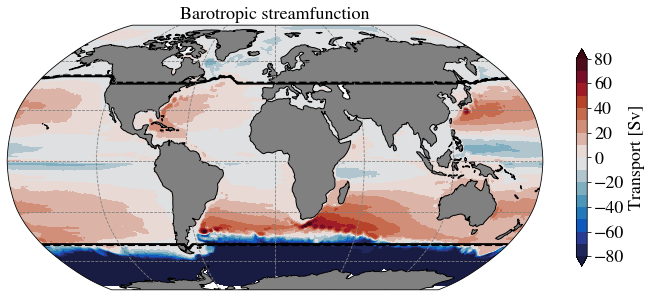

In [220]:
# Grid (used for plotting)
geolon_c = xr.open_dataset('/g/data/ik11/grids/ocean_grid_025.nc').geolon_c
geolat_t = xr.open_dataset('/g/data/ik11/grids/ocean_grid_025.nc').geolat_t

# Define the levels for the contourf
lvls = np.arange(-80, 90, 10)

fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111, projection = ccrs.Robinson())

# Add land features and gridlines
ax.add_feature(cfeature.LAND, edgecolor = 'black', facecolor = 'gray', zorder = 2)
ax.gridlines(color='grey', linestyle='--')

ax.contour(geolon_c, geolat_t, mask_heat, colors = 'black', levels = [-0.05, 0.05], transform=ccrs.PlateCarree(), add_colorbar=False)
# Plot the barotropic stream function
cf = ax.contourf(geolon_c, geolat_t, psi_g, levels = lvls, cmap = cm.cm.balance, extend = 'both',
                 transform = ccrs.PlateCarree())

# Add a colorbar
cbar = fig.colorbar(cf, ax = ax, orientation = 'vertical', shrink = 0.5)
cbar.set_label('Transport [Sv]', size = 18)
ax.set_title('Barotropic streamfunction', size = 18)
#plt.savefig('Figures/heat_map_over_psi.jpeg', bbox_inches = 'tight', dpi = 900, transparent=True)

In the northern hemisphere, heat loss will occur in the region enclosed by dotted black contours, and heat gain will occur in the region enclosed by complete black contours. The opposite is true of Southern Hemisphere.

In [ ]:
# Grid (used for plotting)
geolon_c = xr.open_dataset('/g/data/ik11/grids/ocean_grid_025.nc').geolon_c
geolat_t = xr.open_dataset('/g/data/ik11/grids/ocean_grid_025.nc').geolat_t

# Define the levels for the contourf
lvls = np.arange(-80, 90, 10)

fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111, projection = ccrs.Robinson())

# Add land features and gridlines
ax.add_feature(cfeature.LAND, edgecolor = 'black', facecolor = 'gray', zorder = 2)
ax.gridlines(color='grey', linestyle='--')

ax.contour(geolon_c, geolat_t, psi_g, colors = 'black', levels = [-5, 5], transform=ccrs.PlateCarree(), add_colorbar=False)
#ax.contour(geolon_c, geolat_t, psi_g.where(psi_g.yt_ocean < -10), colors = 'black', levels = [-5, 5], transform=ccrs.PlateCarree(), add_colorbar=False)
# Plot the barotropic stream function
cf = ax.contourf(geolon_c, geolat_t, psi_g, levels = lvls, cmap = cm.cm.balance, extend = 'both',
                 transform = ccrs.PlateCarree())

# Add a colorbar
cbar = fig.colorbar(cf, ax = ax, orientation = 'vertical', shrink = 0.5)
cbar.set_label('Transport [Sv]', size = 18)
ax.set_title('Barotropic streamfunction', size = 18)
#plt.savefig('Figures/psi.jpeg', bbox_inches = 'tight', dpi = 900, transparent=True)

Using streamfunction is a good idea, but it is full of gradients. We need a smoother contour, and we move on to SSH.

## B. Using SSH

In [6]:
SSH = cc.querying.getvar(expt = expt, session = session, variable = 'sea_level', frequency = '1 monthly').sel(time = slice(st, et))
SSH = SSH.mean('time')

In [7]:
geolon_c = xr.open_dataset('/g/data/ik11/grids/ocean_grid_025.nc').geolon_c
geolat_t = xr.open_dataset('/g/data/ik11/grids/ocean_grid_025.nc').geolat_t

Text(0.5, 1.0, 'Sea surface height')

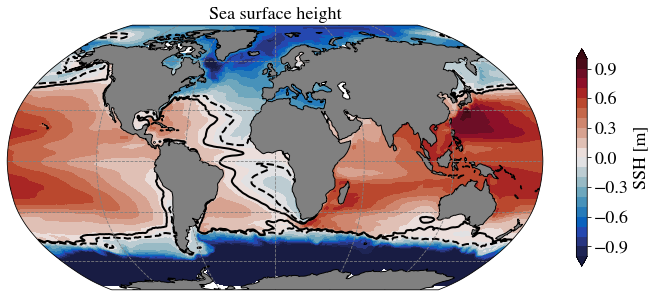

In [9]:
# Grid (used for plotting)
geolon_c = xr.open_dataset('/g/data/ik11/grids/ocean_grid_025.nc').geolon_c
geolat_t = xr.open_dataset('/g/data/ik11/grids/ocean_grid_025.nc').geolat_t

# Define the levels for the contourf
lvls = np.linspace(-1, 1, 21)

fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111, projection = ccrs.Robinson())

# Add land features and gridlines
ax.add_feature(cfeature.LAND, edgecolor = 'black', facecolor = 'gray', zorder = 2)
ax.gridlines(color='grey', linestyle='--')

ax.contour(geolon_c, geolat_t, SSH, colors = 'black', levels = [-0.05, 0.05], transform=ccrs.PlateCarree(), add_colorbar=False)
#ax.contour(geolon_c, geolat_t, SSH), colors = 'black', levels = [-0.05, 0.05], transform=ccrs.PlateCarree(), add_colorbar=False)
# Plot the barotropic stream function
cf = ax.contourf(geolon_c, geolat_t, SSH, levels = lvls, cmap = cm.cm.balance, extend = 'both',
                 transform = ccrs.PlateCarree())

# Add a colorbar
cbar = fig.colorbar(cf, ax = ax, orientation = 'vertical', shrink = 0.5)
cbar.set_label('SSH [m]', size = 18)
ax.set_title('Sea surface height', size = 18)
#plt.savefig('Figures/ssh.jpeg', bbox_inches = 'tight', dpi = 900, transparent=True)

The above SSH plot is a bit weird - it is implying that we should cool in the tropics in the North Atlantic! 
@andy suggested that instead of choosing 0 as the refernce for separation between the heat gain heat loss regions, we can choose a negative value in the North Atlantic. Something like the below plot:

In [ ]:
SSH_atlantic = SSH.where(SSH.xt_ocean > -100)
SSH_atlantic = SSH_atlantic.where(SSH.xt_ocean < 20)

SSH_atlantic1 = SSH_atlantic.where(SSH.yt_ocean > 20)
SSH_atlantic2 = SSH_atlantic.where(SSH.yt_ocean < 20)

SSH_pacific = SSH.where(SSH.xt_ocean > -250)
SSH_pacific = SSH_pacific.where(SSH.xt_ocean < -100)

SSH_indian1 = SSH.where(SSH.xt_ocean > 20)
SSH_indian2 = SSH.where(SSH.xt_ocean < -250)

SSH_NA = SSH.where(SSH.xt_ocean > -100)

Text(0.5, 1.0, 'Sea surface height')

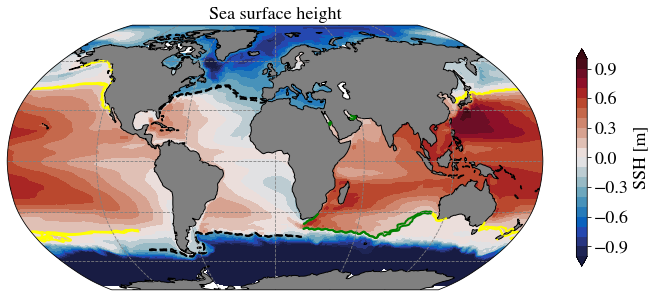

In [11]:
# Grid (used for plotting)
geolon_c = xr.open_dataset('/g/data/ik11/grids/ocean_grid_025.nc').geolon_c
geolat_t = xr.open_dataset('/g/data/ik11/grids/ocean_grid_025.nc').geolat_t

# Define the levels for the contourf
lvls = np.linspace(-1, 1, 21)

fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111, projection = ccrs.Robinson())

# Add land features and gridlines
ax.add_feature(cfeature.LAND, edgecolor = 'black', facecolor = 'gray', zorder = 2)
ax.gridlines(color='grey', linestyle='--')

ax.contour(geolon_c, geolat_t, SSH_atlantic1, colors = 'black', levels = [-0.31, -0.29], transform=ccrs.PlateCarree(), add_colorbar=False)
ax.contour(geolon_c, geolat_t, SSH_atlantic2, colors = 'black', levels = [-0.31, -0.29], transform=ccrs.PlateCarree(), add_colorbar=False)
ax.contour(geolon_c, geolat_t, SSH_pacific, colors = 'yellow', levels = [0.09, 0.11], transform=ccrs.PlateCarree(), add_colorbar=False)
ax.contour(geolon_c, geolat_t, SSH_indian1, colors = 'green', levels = [0.09, 0.11], transform=ccrs.PlateCarree(), add_colorbar=False)
ax.contour(geolon_c, geolat_t, SSH_indian2, colors = 'green', levels = [0.09, 0.11], transform=ccrs.PlateCarree(), add_colorbar=False)
#ax.contour(geolon_c, geolat_t, SSH), colors = 'black', levels = [-0.05, 0.05], transform=ccrs.PlateCarree(), add_colorbar=False)
# Plot the barotropic stream function
cf = ax.contourf(geolon_c, geolat_t, SSH, levels = lvls, cmap = cm.cm.balance, extend = 'both',
                 transform = ccrs.PlateCarree())

# Add a colorbar
cbar = fig.colorbar(cf, ax = ax, orientation = 'vertical', shrink = 0.5)
cbar.set_label('SSH [m]', size = 18)
ax.set_title('Sea surface height', size = 18)
#plt.savefig('Figures/ssh.jpeg', bbox_inches = 'tight', dpi = 900, transparent=True)

## Using different contours for different oceans and smoothing with tanh

In [27]:
# Creating different areas
SSH_atlantic = SSH.where(SSH.xt_ocean > -110)
SSH_atlantic1 = SSH_atlantic.where(SSH.yt_ocean > 20)

SSH_atlantic2 = SSH_atlantic.where(SSH.yt_ocean < 20)
SSH_atlantic2 = SSH_atlantic2.where(SSH.xt_ocean > -65)
SSH_atlantic2 = SSH_atlantic2.where(SSH.xt_ocean < 25)

SSH_pacific = SSH.where(SSH.xt_ocean > -250)
SSH_pacific1 = SSH_pacific.where(SSH.yt_ocean > 20)
SSH_pacific1 = SSH_pacific1.where(SSH.xt_ocean < -100)

SSH_pacific2 = SSH_pacific.where(SSH.yt_ocean < 20)
SSH_pacific2 = SSH_pacific2.where(SSH.xt_ocean < -80)

Text(0.5, 1.0, 'Sea surface height')

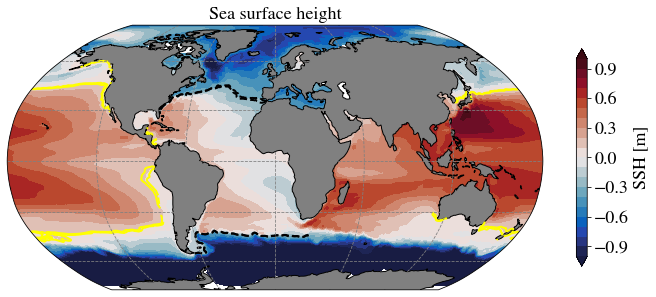

In [28]:
# Grid (used for plotting)
geolon_c = xr.open_dataset('/g/data/ik11/grids/ocean_grid_025.nc').geolon_c
geolat_t = xr.open_dataset('/g/data/ik11/grids/ocean_grid_025.nc').geolat_t

# Define the levels for the contourf
lvls = np.linspace(-1, 1, 21)

fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111, projection = ccrs.Robinson())

# Add land features and gridlines
ax.add_feature(cfeature.LAND, edgecolor = 'black', facecolor = 'gray', zorder = 2)
ax.gridlines(color='grey', linestyle='--')

ax.contour(geolon_c, geolat_t, SSH_atlantic1, colors = 'black', levels = [-0.31, -0.29], transform=ccrs.PlateCarree(), add_colorbar=False)
ax.contour(geolon_c, geolat_t, SSH_atlantic2, colors = 'black', levels = [-0.31, -0.29], transform=ccrs.PlateCarree(), add_colorbar=False)
ax.contour(geolon_c, geolat_t, SSH_pacific1, colors = 'yellow', levels = [0.09, 0.11], transform=ccrs.PlateCarree(), add_colorbar=False)
ax.contour(geolon_c, geolat_t, SSH_pacific2, colors = 'yellow', levels = [0.09, 0.11], transform=ccrs.PlateCarree(), add_colorbar=False)

# Plot the barotropic stream function
cf = ax.contourf(geolon_c, geolat_t, SSH, levels = lvls, cmap = cm.cm.balance, extend = 'both',
                 transform = ccrs.PlateCarree())

# Adding xticks
# Add a colorbar
cbar = fig.colorbar(cf, ax = ax, orientation = 'vertical', shrink = 0.5)
cbar.set_label('SSH [m]', size = 18)
ax.set_title('Sea surface height', size = 18)

Text(0.5, 1.0, 'Sea surface height')

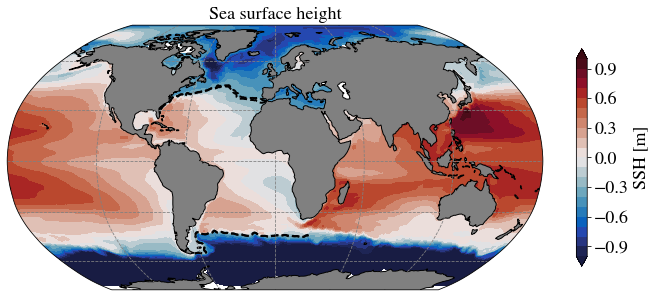

In [20]:
# Grid (used for plotting)
geolon_c = xr.open_dataset('/g/data/ik11/grids/ocean_grid_025.nc').geolon_c
geolat_t = xr.open_dataset('/g/data/ik11/grids/ocean_grid_025.nc').geolat_t

# Define the levels for the contourf
lvls = np.linspace(-1, 1, 21)

fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111, projection = ccrs.Robinson())

# Add land features and gridlines
ax.add_feature(cfeature.LAND, edgecolor = 'black', facecolor = 'gray', zorder = 2)
ax.gridlines(color='grey', linestyle='--')

ax.contour(geolon_c, geolat_t, SSH_atlantic1, colors = 'black', levels = [-0.31, -0.29], transform=ccrs.PlateCarree(), add_colorbar=False)
ax.contour(geolon_c, geolat_t, SSH_atlantic2, colors = 'black', levels = [-0.31, -0.29], transform=ccrs.PlateCarree(), add_colorbar=False)

# Plot the barotropic stream function
cf = ax.contourf(geolon_c, geolat_t, SSH, levels = lvls, cmap = cm.cm.balance, extend = 'both',
                 transform = ccrs.PlateCarree())

# Adding xticks
# Add a colorbar
cbar = fig.colorbar(cf, ax = ax, orientation = 'vertical', shrink = 0.5)
cbar.set_label('SSH [m]', size = 18)
ax.set_title('Sea surface height', size = 18)

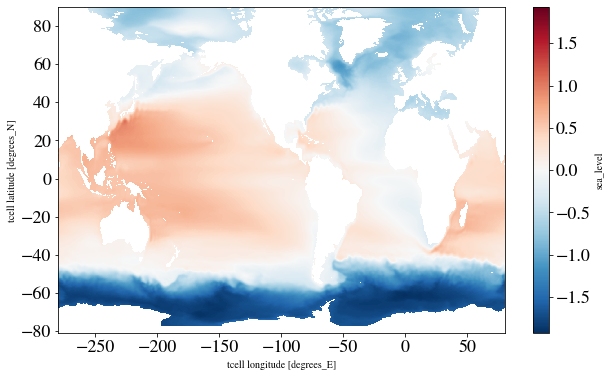

In [21]:
plt.figure(figsize = (10, 6))
SSH.plot()

## Creating a mask

Now we know that SSH is a better diagnostic for our contour mapping because:
1. Contours using SSH are more smooth, and
2. SSH is representative of the gyre extent.

We apply the following boundary conditions to our plot:
1. Everything after 47 degrees N/S must be negative.
2. Everything less than 40 degrees N/S must be positive.
3. In NP, SSH > 0.05 m for positive value.
4. In SP and IO, SSH > 0 m for positive value.
5. In SP and IO, every value equatorward of 46 degrees S must be positive.
6. In SA, SSH > -0.2 m for positive value.
7. In NA, SSH > -0.3 m for positive value. 

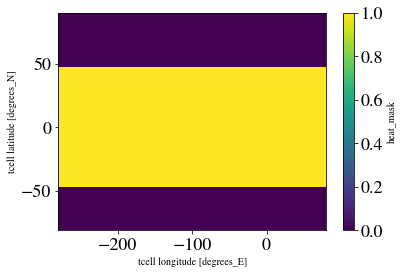

In [38]:
geolon_c = xr.open_dataset('/g/data/ik11/grids/ocean_grid_025.nc').geolon_t
geolat_t = xr.open_dataset('/g/data/ik11/grids/ocean_grid_025.nc').geolat_t

SSH = cc.querying.getvar(expt = expt, session = session, variable = 'sea_level', frequency = '1 monthly').sel(time = slice(st, et))
SSH = SSH.mean('time')

mask = np.ones((1080, 1440))
mask_init = xr.DataArray(mask, coords = [geolat_t.yt_ocean, geolat_t.xt_ocean], dims = ['yt_ocean', 'xt_ocean'], name = 'heat_mask', attrs = {'units':'none'})

#temp = cc.querying.getvar(expt = expt, session = session, variable = 'temp', n = 1)
#temp = temp.isel(time = 0).isel(st_ocean = 0)
#mask_land = temp/temp

mask_land1 = mask_init.where(abs(mask_init.yt_ocean) < 47, 0)
mask_land2 = mask_init.where(mask_init.yt_ocean > -47, 0)
mask_land3 = mask_init.where(mask_init.yt_ocean > 47, 0)
mask_land = mask_land1 + mask_land2 - mask_land3
mask_land = xr.ufuncs.sign(mask_land)
mask_land.plot()

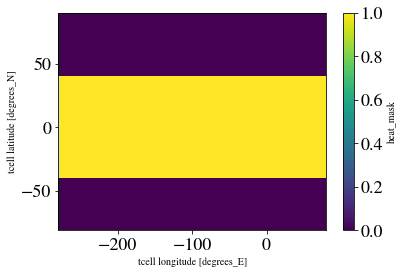

In [39]:
mask_alltrue1 = mask_init.where(abs(mask_init.yt_ocean) < 40, 0)
mask_alltrue2 = mask_init.where(mask_init.yt_ocean > -40, 0)
mask_alltrue3 = mask_init.where(mask_init.yt_ocean > 40, 0)
mask_alltrue = mask_alltrue1 + mask_alltrue2 - mask_alltrue3
mask_alltrue = xr.ufuncs.sign(mask_alltrue)
mask_alltrue.plot()

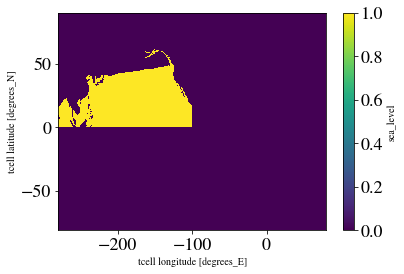

In [40]:
SSH_NPacific = SSH.where(SSH.xt_ocean < -100)
SSH_NPacific = SSH_NPacific.where(SSH.yt_ocean > 0)
mask_NPacific = xr.where(SSH_NPacific > 0.05, 1, 0)
mask_NPacific.plot()

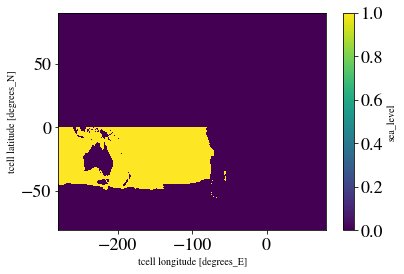

In [41]:
SSH_SPacific = SSH.where(SSH.xt_ocean < -55)
SSH_SPacific = SSH_SPacific.where(SSH.yt_ocean < 0)
mask_SPacific = xr.where(SSH_SPacific > 0.0, 1, 0)
mask_SPacific.plot()

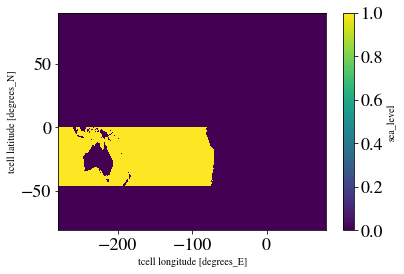

In [42]:
SSH_SP_correction = SSH.where(SSH.xt_ocean < -70)
#SSH_SP_correction = SSH_SP_correction.where(SSH.xt_ocean > -220)
SSH_SP_correction = SSH_SP_correction.where(SSH.yt_ocean < 0)
SSH_SP_correction = SSH_SP_correction.where(SSH.yt_ocean > -46)
mask_SP_correction = xr.where(SSH_SP_correction > -1, 1, 0)
mask_SP_correction.plot()

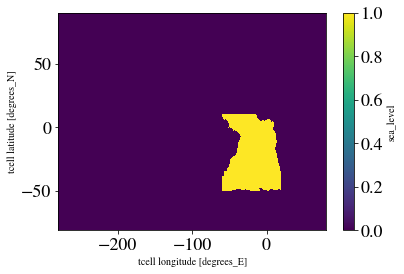

In [43]:
SSH_SA_correction = SSH.where(SSH.xt_ocean > -60)
SSH_SA_correction = SSH_SA_correction.where(SSH.xt_ocean < 20)
SSH_SA_correction = SSH_SA_correction.where(SSH.yt_ocean < 10)
SSH_SA_correction = SSH_SA_correction.where(SSH.yt_ocean > -50)
mask_SA_correction = xr.where(SSH_SA_correction > -1, 1, 0)
mask_SA_correction.plot()

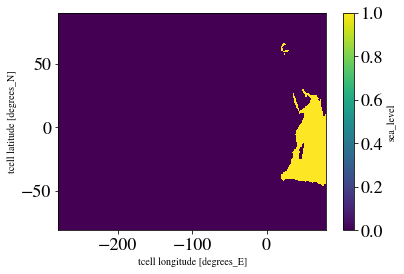

In [44]:
SSH_Indian = SSH.where(SSH.xt_ocean > 20)
mask_Indian = xr.where(SSH_Indian > 0.0, 1, 0)
mask_Indian.plot()

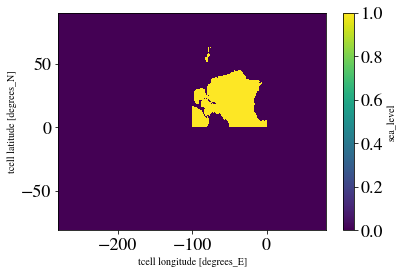

In [45]:
SSH_NAtlantic = SSH.where(SSH.xt_ocean > -100)
SSH_NAtlantic = SSH_NAtlantic.where(SSH.xt_ocean < 0)
SSH_NAtlantic = SSH_NAtlantic.where(SSH.yt_ocean > 0)
mask_NAtlantic = xr.where(SSH_NAtlantic > -0.3, 1, 0)
mask_NAtlantic.plot()

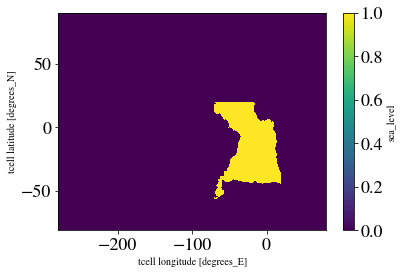

In [46]:
SSH_SAtlantic = SSH.where(SSH.xt_ocean > -70)
SSH_SAtlantic = SSH_SAtlantic.where(SSH.xt_ocean < 20)
SSH_SAtlantic = SSH_SAtlantic.where(SSH.yt_ocean < 20)
mask_SAtlantic = xr.where(SSH_SAtlantic > -0.2, 1, 0)
mask_SAtlantic.plot()

In [47]:
mask_heat = (mask_NAtlantic + mask_SAtlantic * mask_SA_correction + mask_NPacific + mask_SPacific + mask_SP_correction + mask_Indian + mask_alltrue) * mask_land
mask_heat = xr.where(mask_heat > 0.0, 1, -1)
#mask_heat = mask_heat.interp(yt_ocean.)

Text(0.5, 1.0, 'Heat flux mask')

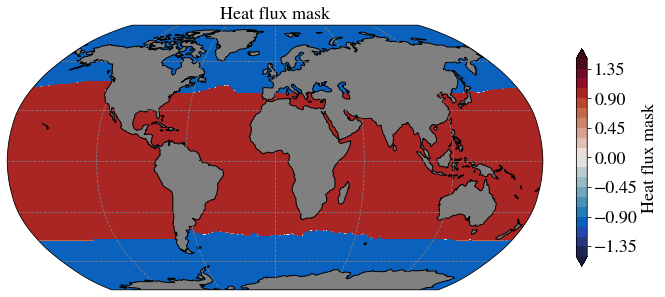

In [48]:
# Grid (used for plotting)
geolon_c = xr.open_dataset('/g/data/ik11/grids/ocean_grid_025.nc').geolon_c
geolat_t = xr.open_dataset('/g/data/ik11/grids/ocean_grid_025.nc').geolat_t

# Define the levels for the contourf
lvls = np.linspace(-1.5, 1.5, 21)

fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111, projection = ccrs.Robinson())

# Add land features and gridlines
ax.add_feature(cfeature.LAND, edgecolor = 'black', facecolor = 'gray', zorder = 2)
ax.gridlines(color='grey', linestyle='--')

# Plot the barotropic stream function
cf = ax.contourf(geolon_c, geolat_t, mask_heat, levels = lvls, cmap = cm.cm.balance, extend = 'both',
                 transform = ccrs.PlateCarree())

# Adding xticks
# Add a colorbar
cbar = fig.colorbar(cf, ax = ax, orientation = 'vertical', shrink = 0.5)
cbar.set_label('Heat flux mask', size = 18)
ax.set_title('Heat flux mask', size = 18)

#plt.savefig('Figures/heat_map.jpeg', bbox_inches = 'tight', dpi = 900, transparent=True)

Text(0.5, 1.0, 'Sea surface height')

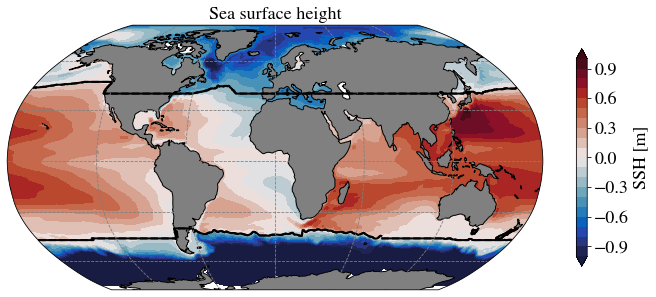

In [49]:
# Grid (used for plotting)
geolon_c = xr.open_dataset('/g/data/ik11/grids/ocean_grid_025.nc').geolon_c
geolat_t = xr.open_dataset('/g/data/ik11/grids/ocean_grid_025.nc').geolat_t

# Define the levels for the contourf
lvls = np.linspace(-1, 1, 21)

fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111, projection = ccrs.Robinson())

# Add land features and gridlines
ax.add_feature(cfeature.LAND, edgecolor = 'black', facecolor = 'gray', zorder = 2)
ax.gridlines(color='grey', linestyle='--')

ax.contour(geolon_c, geolat_t, mask_heat, colors = 'black', levels = [-0.05, 0.05], transform=ccrs.PlateCarree(), add_colorbar=False)

# Plot the barotropic stream function
cf = ax.contourf(geolon_c, geolat_t, SSH, levels = lvls, cmap = cm.cm.balance, extend = 'both',
                 transform = ccrs.PlateCarree())

# Add a colorbar
cbar = fig.colorbar(cf, ax = ax, orientation = 'vertical', shrink = 0.5)
cbar.set_label('SSH [m]', size = 18)
ax.set_title('Sea surface height', size = 18)

Text(0.5, 1.0, 'Barotropic streamfunction')

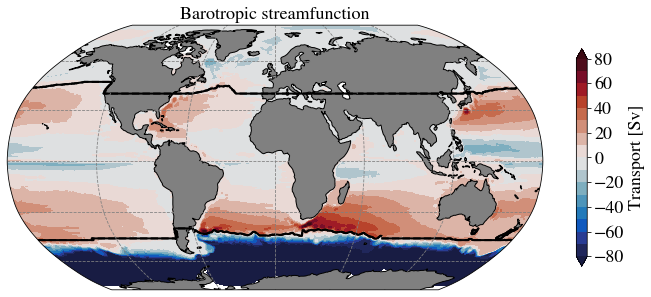

In [70]:
# Grid (used for plotting)
geolon_c = xr.open_dataset('/g/data/ik11/grids/ocean_grid_025.nc').geolon_c
geolat_t = xr.open_dataset('/g/data/ik11/grids/ocean_grid_025.nc').geolat_t

# Define the levels for the contourf
lvls = np.arange(-80, 90, 10)

fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111, projection = ccrs.Robinson())

# Add land features and gridlines
ax.add_feature(cfeature.LAND, edgecolor = 'black', facecolor = 'gray', zorder = 2)
ax.gridlines(color='grey', linestyle='--')

ax.contour(geolon_c, geolat_t, mask_heat, colors = 'black', levels = [-0.05, 0.05], transform=ccrs.PlateCarree(), add_colorbar=False)
# Plot the barotropic stream function
cf = ax.contourf(geolon_c, geolat_t, psi_g, levels = lvls, cmap = cm.cm.balance, extend = 'both',
                 transform = ccrs.PlateCarree())

# Add a colorbar
cbar = fig.colorbar(cf, ax = ax, orientation = 'vertical', shrink = 0.5)
cbar.set_label('Transport [Sv]', size = 18)
ax.set_title('Barotropic streamfunction', size = 18)
#plt.savefig('Figures/heat_map_over_psi.jpeg', bbox_inches = 'tight', dpi = 900, transparent=True)

## Interpolating values at the junction of +-1 of the mask using multiple linear convolutions

Suppose we have a series of points:

Points:         x0    x1    x2    x3    x4    x5    x6    x7    x8    x9

Values:          0     0     0     0     0     1     1     1     1     1

and we wish to take a rolling mean. We demonstrate here that rolling mean is equivalent to a convolution. Not only this, each level of convolution signifies a higher order polynomial being used for the rolling mean.

Level 1 conv:    0     0     0     0    1/3   2/3    1     1     1     1

Level 2 conv:    0     0     0    1/9   1/3   2/3   8/9    1     1     1

Level 3 conv:    0     0    1/27  4/27 10/27 17/27 23/27  26/27  1     1

We see that each level of convolution follows the relation:

\begin{equation}
    z = \Big| x - \frac{x4 + x5}{2}\Big|^{\alpha} + c
\end{equation}

where $\alpha$ is the level of convolution and c is the constant. 

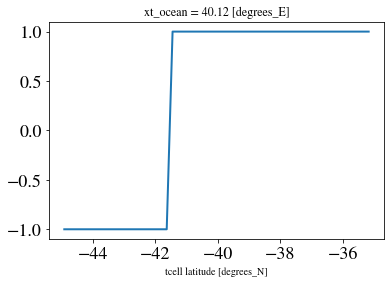

In [51]:
mask_heat.sel(xt_ocean = 40, method = 'nearest').sel(yt_ocean = slice(-45, -35)).plot()

Text(0.5, 1.0, 'Convolution of a function')

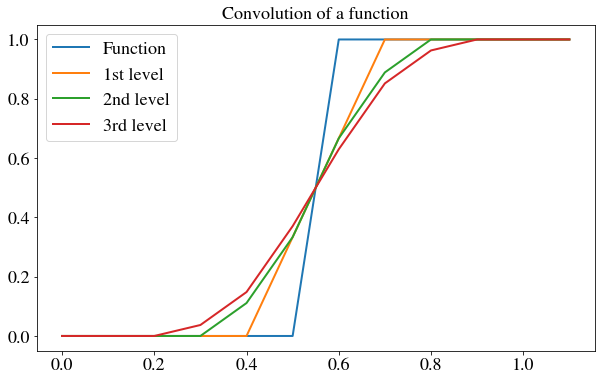

In [52]:
plt.figure(figsize = (10, 6))

y = [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]
x = np.linspace(0, 1.1, 12)
y1 = [0, 0, 0, 0, 0, 1/3, 2/3, 1 , 1 , 1 , 1, 1]
y2 = [0, 0, 0, 0, 1/9, 1/3, 2/3, 8/9 , 1 , 1 , 1, 1]
y3 = [0, 0, 0, 1/27, 4/27, 10/27, 17/27 , 23/27 , 26/27, 1, 1, 1]
plt.plot(x, y, label = 'Function')
plt.plot(x, y1, label = '1st level')
plt.plot(x, y2, label = '2nd level')
plt.plot(x, y3, label = '3rd level')

plt.legend(fontsize = 18)
plt.title('Convolution of a function', size = 18)

Text(0.5, 1.0, 'Heat flux mask')

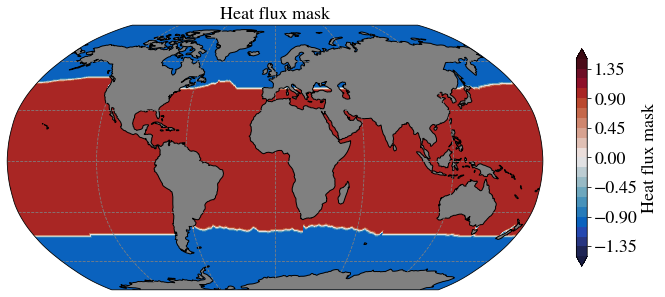

In [53]:
for i in range(0, 10):
    mask_heat = mask_heat.rolling(yt_ocean = 4, min_periods = 1).mean()
    
## Plotting
    
# Grid (used for plotting)
geolon_c = xr.open_dataset('/g/data/ik11/grids/ocean_grid_025.nc').geolon_c
geolat_t = xr.open_dataset('/g/data/ik11/grids/ocean_grid_025.nc').geolat_t

# Define the levels for the contourf
lvls = np.linspace(-1.5, 1.5, 21)

fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111, projection = ccrs.Robinson())

# Add land features and gridlines
ax.add_feature(cfeature.LAND, edgecolor = 'black', facecolor = 'gray', zorder = 2)
ax.gridlines(color='grey', linestyle='--')

# Plot the barotropic stream function
cf = ax.contourf(geolon_c, geolat_t, mask_heat, levels = lvls, cmap = cm.cm.balance, extend = 'both',
                 transform = ccrs.PlateCarree())

# Adding xticks
# Add a colorbar
cbar = fig.colorbar(cf, ax = ax, orientation = 'vertical', shrink = 0.5)
cbar.set_label('Heat flux mask', size = 18)
ax.set_title('Heat flux mask', size = 18)

#plt.savefig('Figures/heat_map.jpeg', bbox_inches = 'tight', dpi = 900, transparent=True)

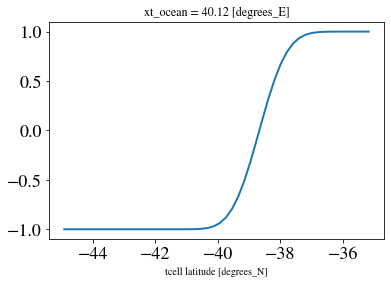

In [54]:
mask_heat.sel(xt_ocean = 40, method = 'nearest').sel(yt_ocean = slice(-45, -35)).plot()

## Interpolating values at the junction of +-1 of the mask using tanh function

In [55]:
mask_heat = (mask_NAtlantic + mask_SAtlantic * mask_SA_correction + mask_NPacific + mask_SPacific + mask_SP_correction + mask_Indian + mask_alltrue) * mask_land
mask_heat = xr.where(mask_heat > 0.0, 1, -1)
mask_heat_old = mask_heat.values
mask_heat_new = mask_heat.values

In [56]:
xt = np.arange(0, 1440)
yt = np.arange(0, 1080)

Y, X = np.meshgrid(yt,xt)

In [57]:
dy = 200
dyby2 = 100

i = dyby2 + 1
j = 0

mask_heat_new = mask_heat.values
mask_heat_new = mask_heat_new.astype(np.float)

while j < 1440:
    i = dyby2 + 1
    while i < 1080 - dyby2:
        if((mask_heat_new[i, j]!=mask_heat_new[i+1,j]) and (mask_heat_new[i,j] == 1 or mask_heat_new[i,j] == -1) and (mask_heat_new[i+1,j] == 1 or mask_heat_new[i+1,j] == -1)):
            if(mask_heat_new[i,j] == 1 and mask_heat_new[i+1,j] == -1):
                mask_heat_new[i-dyby2:i+dyby2,j] = np.tanh((-yt[i-dyby2:i+dyby2] + i)/20)
                i = i + 25
            elif(mask_heat_new[i,j] == -1 and mask_heat_new[i+1,j] == +1):
                mask_heat_new[i-dyby2:i+dyby2,j] = np.tanh((yt[i-dyby2:i+dyby2] - i)/20)
                i = i + 25
        i = i + 1
    j = j + 1

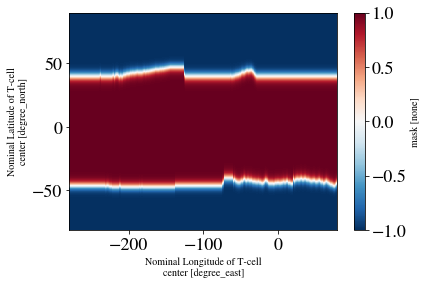

In [58]:
from netCDF4 import Dataset

nc_file = '/g/data/ik11/inputs/access-om2/input_20200530/mom_025deg/ocean_temp_salt.res.nc'
nc_dataset = Dataset(nc_file, mode = 'r')
ocean_dataset = xr.open_dataset(xr.backends.NetCDF4DataStore(nc_dataset))

x = ocean_dataset.GRID_X_T
y = ocean_dataset.GRID_Y_T

mask_da = xr.DataArray(mask_heat_new, coords = [y, x], dims = ['yt_ocean', 'xt_ocean'], name = 'mask', attrs = {'units':'none'})
mask_da.plot()

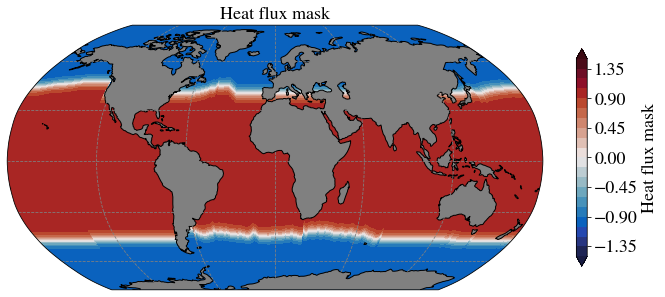

In [67]:
# Grid (used for plotting)
geolon_c = xr.open_dataset('/g/data/ik11/grids/ocean_grid_025.nc').geolon_c
geolat_t = xr.open_dataset('/g/data/ik11/grids/ocean_grid_025.nc').geolat_t

# Define the levels for the contourf
lvls = np.linspace(-1.5, 1.5, 21)

fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111, projection = ccrs.Robinson())

# Add land features and gridlines
ax.add_feature(cfeature.LAND, edgecolor = 'black', facecolor = 'gray', zorder = 2)
ax.gridlines(color='grey', linestyle='--')

# Plot the barotropic stream function
cf = ax.contourf(geolon_c, geolat_t, mask_heat_new, levels = lvls, cmap = cm.cm.balance, extend = 'both',
                 transform = ccrs.PlateCarree())

# Adding xticks
# Add a colorbar
cbar = fig.colorbar(cf, ax = ax, orientation = 'vertical', shrink = 0.5)
cbar.set_label('Heat flux mask', size = 18)
ax.set_title('Heat flux mask', size = 18)

#plt.savefig('Figures/heat_map_tanh.jpeg', bbox_inches = 'tight', dpi = 900, transparent=True)

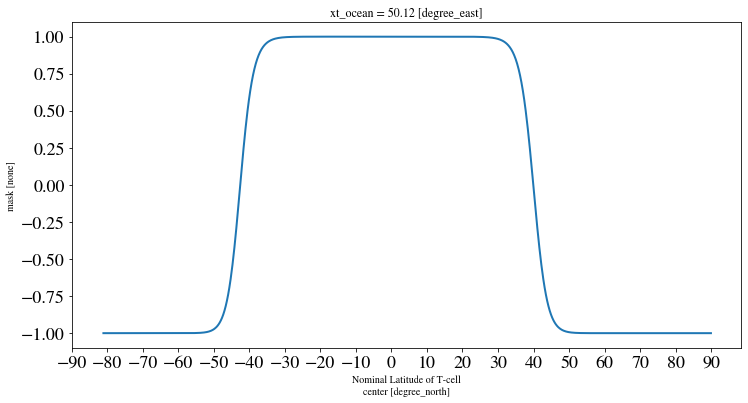

In [69]:
plt.figure(figsize = (12, 6))
mask_da.sel(xt_ocean = 50, method = 'nearest').plot()
plt.xticks(np.linspace(-90, 90, 19))

plt.savefig('Figures/tanh_one_lon.jpeg', bbox_inches = 'tight', dpi = 900, transparent=True)

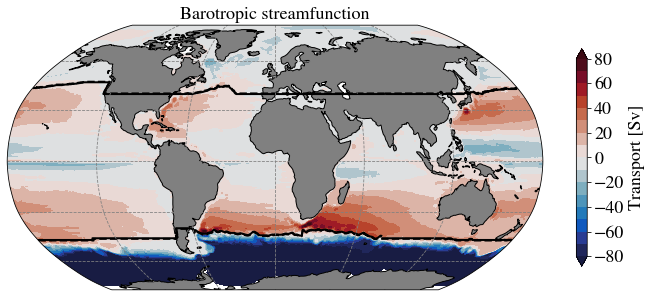

In [71]:
# Grid (used for plotting)
geolon_c = xr.open_dataset('/g/data/ik11/grids/ocean_grid_025.nc').geolon_c
geolat_t = xr.open_dataset('/g/data/ik11/grids/ocean_grid_025.nc').geolat_t

# Define the levels for the contourf
lvls = np.arange(-80, 90, 10)

fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111, projection = ccrs.Robinson())

# Add land features and gridlines
ax.add_feature(cfeature.LAND, edgecolor = 'black', facecolor = 'gray', zorder = 2)
ax.gridlines(color='grey', linestyle='--')

ax.contour(geolon_c, geolat_t, mask_da, colors = 'black', levels = [-0.05, 0.05], transform=ccrs.PlateCarree(), add_colorbar=False)
# Plot the barotropic stream function
cf = ax.contourf(geolon_c, geolat_t, psi_g, levels = lvls, cmap = cm.cm.balance, extend = 'both',
                 transform = ccrs.PlateCarree())

# Add a colorbar
cbar = fig.colorbar(cf, ax = ax, orientation = 'vertical', shrink = 0.5)
cbar.set_label('Transport [Sv]', size = 18)
ax.set_title('Barotropic streamfunction', size = 18)
plt.savefig('Figures/heat_map_tanh_over_psi.jpeg', bbox_inches = 'tight', dpi = 900, transparent=True)

## Saving mask to a netCDF file

In [72]:
mask_ds = mask_da.to_dataset()

mask_ds.to_netcdf(path = '/scratch/x77/db6174/025deg_inputs/flux_forced_uniform_heat/heat_mask.nc', mode = 'w', format = "NETCDF4", engine = "netcdf4")